## Consider margins of error

Want to mask out any anomaly where it is smaller than the estimated margin of error for that grid cell, for that month. 

### Set environment

In [1]:
#--- Libraries
import matplotlib.pyplot as plt      # plotting package
import seaborn as sns                # plotting aestetics
import netCDF4 as nc                 # package to read NetCDF files
import pandas as pd               # packages for statistics
import numpy as np                   # packages for linear algebra

from mpl_toolkits.axes_grid1 import ImageGrid       # plot setting libraries
from mpl_toolkits.basemap import Basemap            # map making libraries
from cdo import *                                   # access external NetCDF data processing routines
cdo = Cdo()                          

%matplotlib inline


### View examples of data

In [2]:
#--- Arrange data
# load data files
ncfile_anom = nc.Dataset('data/precip.mon.mean.safr.anom.elnino.nc')
ncfile_mask = nc.Dataset('data/mask.abserror.safr.elnino.nc')
# get coordinates of data
lons = ncfile_anom.variables['lon'][:]
lats = ncfile_anom.variables['lat'][:]
# add extra point for grid fill
lons = np.append(lons,lons[-1]+2)
lats = np.append(lats,lats[-1]-2)
# set coordinates list as grid of locations
lons, lats = np.meshgrid(lons,lats)
# shift so that lines show grid box boundaries, 
#    rather than grid point locations
lons = lons - (2/2)
lats = lats + (2/2)
# create list of month names
months = ['January', 'February', 'March', 'April', 
          'May', 'June', 'July', 'August',
          'September', 'October', 'November', 'December']

Take the mask file created earlier and shade over any anomalies that are below the suggested error threshold. 

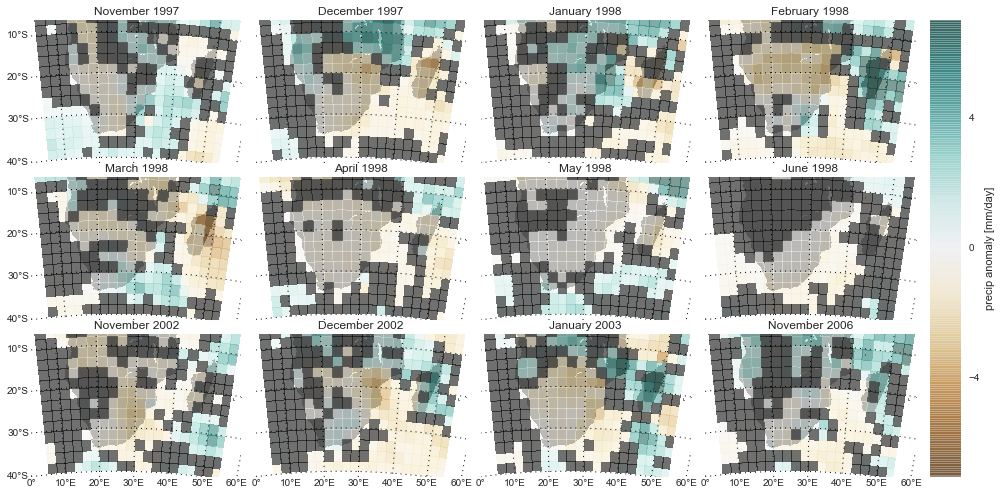

In [3]:
#--- Show some example time slices, with masking
# select samples
start = 53 ; stop = start+12
# record dates
sample_dates = cdo.showdate(input='data/precip.mon.mean.safr.anom.elnino.nc')[0].split()[start:stop]
# create date labels
sample_dates = map(lambda x: months[int(x.split('-')[1])-1] +' '+x.split('-')[0], sample_dates)
# initiate counter
c = 0 
# set image
fig = plt.figure(figsize=(22.,18.)) 
plt.figure() 
# divide into a grid, with common color bar
grid_top = ImageGrid(fig, 211, nrows_ncols = (3, 4),
                     cbar_location = "right",
                     cbar_mode="single",
                     cbar_pad=.2,
                     axes_pad=.2) 
# loop over grid elements
for g, node in zip(grid_top,ncfile_anom.variables['precip'][start:stop]):
    # go to current grid element
    plt.sca(g) 
    # set region/projection
    chart = Basemap(projection='lcc',resolution='c',
                    lat_0=-17,lon_0=25,
                    llcrnrlat=-40,urcrnrlat=-5.,
                    llcrnrlon=0,urcrnrlon=55) 
    # mark land mass
    chart.drawlsmask(land_color='gray') 
    # draw parallels and meridian on border maps
    if (c == 0 or c == 4) :
        _ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,False],dashes=[1,4])
        _ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,False],dashes=[1,4])
    elif (c == 9 or c == 10 or c == 11) :
        _ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[False,False,False,False],dashes=[1,4])
        _ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[1,4])
    elif (c == 8) :
        _ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,False],dashes=[1,4])
        _ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[1,4])
    else :
        _ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[False,False,False,False],dashes=[1,4])
        _ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,False],dashes=[1,4])
    # overlay precip anomaly
#     Z = ncfile_mask.variables['precip'][c+start]
#     node_m = np.ma.masked_where(Z > 0.2,node)
    sm = chart.pcolormesh(lons,lats,node,shading='flat',latlon=True,
                          alpha=0.5,cmap='BrBG',vmin=-7,vmax=7)
    # read mask file
    Z = ncfile_mask.variables['precip'][c+start]
    # only consider values where mask=True
    Zm = np.ma.masked_where(Z < 0.2,Z)
    # shade out anomalies below estimated error range
    ms = chart.pcolormesh(lons,lats,Zm,
                          shading='flat',latlon=True,
                          alpha=0.55,cmap='Greys',vmin=0,vmax=1)
    # label nodes
    plt.title(sample_dates[c])
    
    # iterate counter
    c += 1
    
# add color bar 
cb = grid_top.cbar_axes[0].colorbar(sm)
cax = grid_top.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text('precip anomaly [mm/day]')

# save figure
plt.savefig('elnino_samples_masked.png')
